In [0]:
!pip install pytorch-pretrained-bert

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
sharedGFolderPath = "/content/gdrive/My Drive/TUM/NLP Lab/Colab Notebooks/common/"

In [0]:
import os
import argparse
import logging
import json
import re

import torch
import torch.optim as optimizers
import torch.nn as nn

from sklearn.metrics import classification_report

from torch.utils.data import DataLoader
from pytorch_pretrained_bert import BertTokenizer, BertModel
from pytorch_pretrained_bert.file_utils import WEIGHTS_NAME, CONFIG_NAME
from pytorch_pretrained_bert.optimization import BertAdam

from tqdm import tqdm_notebook, tnrange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tripadvisor import TripadvisorDataset
from organic import OrganicDatasetSingle

In [0]:
class MHCBERT(nn.Module):
    def __init__(self, embedding_dim=768, drop_prob=0.5):
        super(MHCBERT, self).__init__()
        
        self.backbone_dims = [embedding_dim // 2, embedding_dim // 4]
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(drop_prob)
        
        # backbone
        self.backbone = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=self.backbone_dims[0]),
            nn.BatchNorm1d(self.backbone_dims[0]),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
            nn.Linear(in_features=self.backbone_dims[0], out_features=self.backbone_dims[1]),
            nn.BatchNorm1d(self.backbone_dims[1]),
            nn.ReLU()
        )

        # no sigmoid -> returns logits for torch.nn.BCEWithLogitsLoss()
        config_dict = {}
        for domain in config:
            domain_dict = {}
            for head in domain["heads"]:
                if domain["heads"][head]:
                    domain_dict[head] = nn.Linear(in_features=self.backbone_dims[1], out_features=domain["classes"][head])
            config_dict[domain["name"]] = nn.ModuleDict(domain_dict)

        self.heads = nn.ModuleDict(config_dict)

    def forward(self, input_ids, token_type_ids = None, attention_mask = None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask)       
        pooled_output = self.dropout(pooled_output)
        
        backbone_output = self.backbone(pooled_output)

        head_outputs = {}
        for domain in self.heads:
            head_outputs[domain] = {}
            for head in self.heads[domain]:
                head_outputs[domain][head] = self.heads[domain][head](backbone_output)

        return head_outputs
                                     
                                     
class MHCBERTClassifier(nn.Module):
    def __init__(self, embedding_dim=768, drop_prob=0.5):
        super(MHCBERTClassifier, self).__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(drop_prob)
        
        # no sigmoid -> returns logits for torch.nn.BCEWithLogitsLoss()
        config_dict = {}
        for domain in config:
            domain_dict = {}
            for head in domain["heads"]:
                if domain["heads"][head]:
                    domain_dict[head] = nn.Linear(in_features=embedding_dim, out_features=domain["classes"][head])
            config_dict[domain["name"]] = nn.ModuleDict(domain_dict)

        self.heads = nn.ModuleDict(config_dict)

    def forward(self, input_ids, token_type_ids = None, attention_mask = None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)

        head_outputs = {}
        for domain in self.heads:
            head_outputs[domain] = {}
            for head in self.heads[domain]:
                head_outputs[domain][head] = self.heads[domain][head](pooled_output)

        return head_outputs

In [0]:
def do_train_step(domain,isEval=False):
    """
    Wraps a training step as it is the same for all sets.
    :param batch: the batch
    :param domain: the config object for the current domain
    :return: the loss for the step
    """
    data = {"aspect": batch['aspect'].long().to(device), "polarity": batch['polarity'].long().to(device),
            "joint": batch['joint'].long().to(device)}
    sequences = batch['sequence'].to(device)
    masks = batch['mask'].to(device)

    optim.zero_grad()

    logits = model(sequences, token_type_ids=None, attention_mask=masks)
    logits = logits[domain["name"]]

    # backprop
    losses = {}
    for head in domain["heads"]:
        if domain["heads"][head]:
            losses[head] = loss_fun(logits[head], data[head])

    if (len(losses) == 0):
        return 0
    loss = sum(losses.values())
    
    if (isEval == False):
        loss.backward()
        optim.step()
    return loss.item()

In [0]:
def inf_iterator(dl):
    while True:
        for x in iter(dl):
            yield x

In [0]:
def readConfig():
    args = argparse.Namespace()
    args.version = "v1"
    args.steps = 200
    args.batch = 32
    args.concat = False
    args.tripad = sharedGFolderPath + 'data/tripadvisor/'
    args.organic = sharedGFolderPath + 'data/organic/'
    args.semEvalDir = sharedGFolderPath + 'data/semeval/'
    args.semEval = ['semevalRestaurants_combi14', 'semevalLaptops_combi14', 'semevalRestaurants_combi16', 'semevalLaptops_combi16']
    args.save_dir = sharedGFolderPath + 'model/'
    args.eval_interval = 50
    args.learning_rate = 5e-5
    
    return args

In [0]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',datefmt='%m/%d/%Y %H:%M:%S',level=logging.INFO)
logger = logging.getLogger(__name__)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

args = readConfig()
with open(os.path.join(sharedGFolderPath, 'config_single.json')) as json_data_file:
    config = json.load(json_data_file)

In [27]:
# BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = MHCBERTClassifier().to(device)


07/18/2019 18:39:50 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
07/18/2019 18:39:51 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
07/18/2019 18:39:51 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpuyiibmzm
07/18/2019 18:39:55 - INFO - pyt

RuntimeError: ignored

In [0]:
# FOR DATA LOADING

tripad = TripadvisorDataset(args.tripad, tokenizer, train=True)
tripad_train, tripad_eval = torch.utils.data.random_split(tripad, lengths=[int(len(tripad) * 0.9), len(tripad) - int(len(tripad) * 0.9)])
tripad_train_loader = DataLoader(tripad_train, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=True)
tripad_eval_loader = DataLoader(tripad_eval, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=True)
tripad_test = TripadvisorDataset(args.tripad, tokenizer, train=False)
tripad_test_loader = DataLoader(tripad_test, batch_size=64,num_workers=16, drop_last=False, shuffle=False)
config[0]["data_loader"] = tripad_train_loader
config[0]["data_loader_eval"] = tripad_eval_loader
config[0]["data_loader_test"] = tripad_test_loader
config[0]["data_iter"] = inf_iterator(tripad_train_loader)
config[0]["data_test"] = tripad_test

organic_train = OrganicDatasetSingle(args.organic, tokenizer, train=0)
organic_train_loader = DataLoader(organic_train, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=True)
organic_eval = OrganicDatasetSingle(args.organic, tokenizer, train=1)
organic_eval_loader = DataLoader(organic_eval, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=True)
organic_test = OrganicDatasetSingle(args.organic, tokenizer, train=2)
organic_test_loader = DataLoader(organic_test, batch_size=args.batch, num_workers=16, drop_last=False, shuffle=True)
config[1]["data_loader"] = organic_train_loader
config[1]["data_loader_eval"] = organic_eval_loader
config[1]["data_loader_test"] = organic_test_loader
config[1]["data_iter"] = inf_iterator(organic_train_loader)
config[1]["data_test"] = organic_test


# RUN ONLY TO FINE TUNE TRAINED COMMON MODEL FOR 1 DOMAIN

In [0]:
config_new = []
config_new.append(config[1])
config = config_new

'''
args.save_dir = sharedGFolderPath + 'model/test/'

model.to('cpu')
model.load_state_dict(torch.load(os.path.join(args.save_dir, 'test.bin')))
model.to(device)
'''

In [28]:
# Prepare optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optim = BertAdam(optimizer_grouped_parameters, lr=args.learning_rate)
    
# loss
#loss_fun = nn.BCEWithLogitsLoss()
loss_fun = nn.CrossEntropyLoss()
#loss = loss_fun(logits.view(-1, num_labels), label_ids.view(-1))

logger.info('***** Running training *****')
logger.info('  Steps = %d', args.steps)
logger.info('  Batch size = %d', args.batch)

domain_losses = {}
domain_eval_losses = {}
for domain in config:
    domain_losses[domain["name"]] = []
    domain_eval_losses[domain["name"]] = []
    
model.train()
# TRAINING LOOP
with tnrange(args.steps, desc="Training Steps") as stepLoop:
    for i in stepLoop:
        for domain in config:
            batch = next(domain["data_iter"])
            current_loss = do_train_step(domain)
            stepLoop.set_postfix(loss=current_loss, domain=domain["name"])
            domain_losses[domain["name"]].append(current_loss)
            if i % 50 == 49:
                print('Step {0} - {1} Loss {2:.4f}'.format(i + 1, domain["name"], current_loss))

        if i % args.eval_interval == args.eval_interval - 1:
            for domain in config:
                loss = 0.0
                with tqdm_notebook(domain["data_loader_eval"]) as evalLoop:
                    for batch in evalLoop:
                        current_loss = do_train_step(domain,isEval=True)
                        loss += current_loss
                        evalLoop.set_postfix(loss=current_loss, domain=domain["name"])

                    domain_eval_losses[domain["name"]].append(loss / len(domain["data_loader_eval"]))
                    print('Evaluation - {0} Loss {1:.4f}'.format(domain["name"], domain_eval_losses[domain["name"]][-1]))

logger.info('Writing model to %s', args.save_dir)
torch.save(model.state_dict(), os.path.join(args.save_dir, WEIGHTS_NAME))
model.bert.config.to_json_file(os.path.join(args.save_dir, CONFIG_NAME))
tokenizer.save_vocabulary(args.save_dir)


07/18/2019 18:39:58 - WARNING - pytorch_pretrained_bert.optimization -   t_total value of -1 results in schedule not being applied
07/18/2019 18:39:58 - INFO - __main__ -   ***** Running training *****
07/18/2019 18:39:58 - INFO - __main__ -     Steps = 200
07/18/2019 18:39:58 - INFO - __main__ -     Batch size = 32


KeyError: ignored

In [0]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

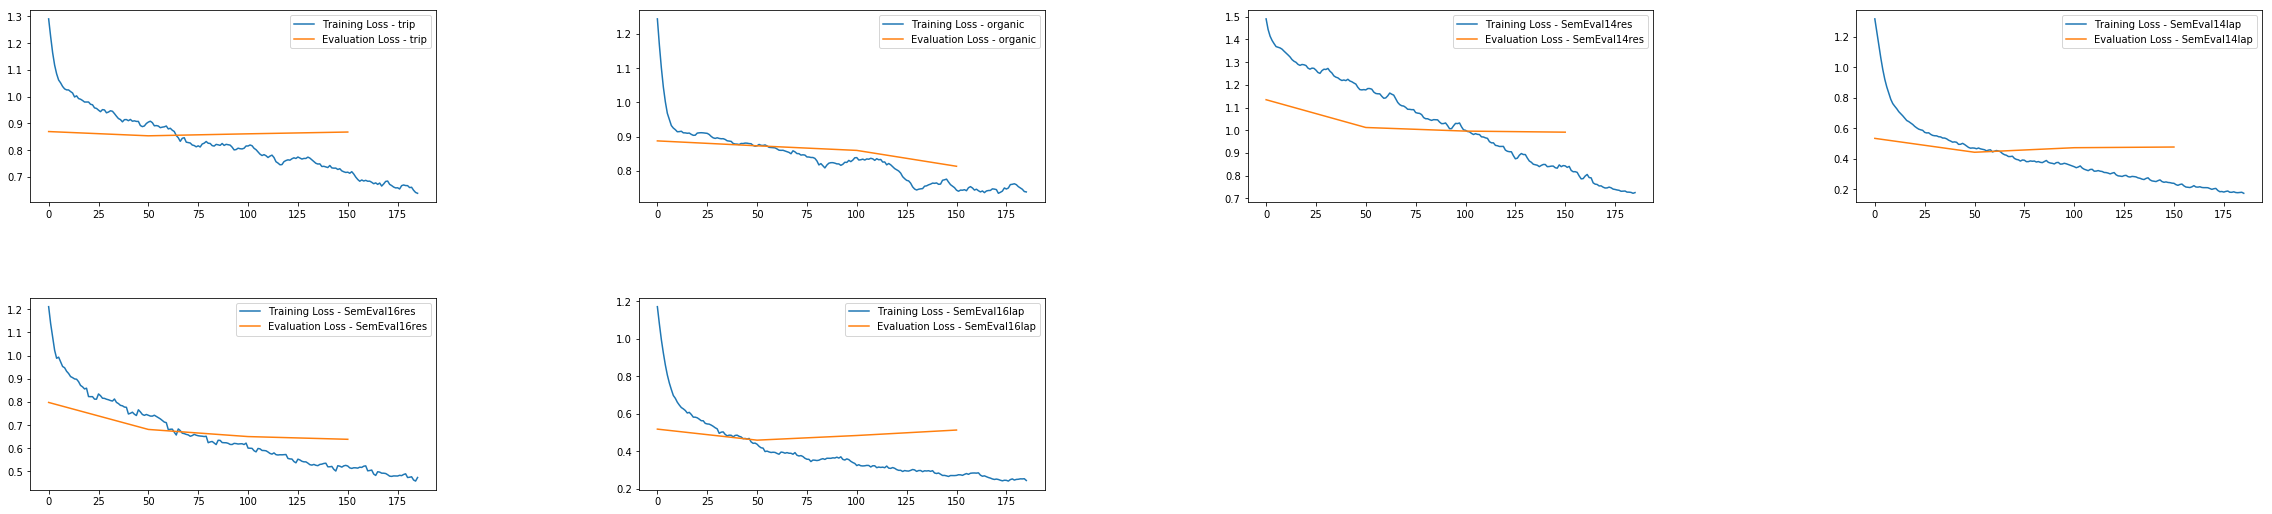

In [0]:
#@title Default title text
'''
domain_losses_mean = {}
for domain in config:
    domain_losses_mean[domain["name"]] = []
    for i in range(len(domain_eval_losses[domain["name"]])):
        domain_losses_mean[domain["name"]].append(np.mean(domain_losses[domain["name"]]
                                                          [i*args.eval_interval:(i+1)*args.eval_interval]))
'''
#plt.figure(figsize=(20,10))
fig = plt.figure(figsize=(40, 30))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i,domain in enumerate(config):
    splt = fig.add_subplot(6, 4, i+1)
    splt.plot(running_mean(domain_losses[domain["name"]],15),label='Training Loss - '+domain["name"])
    splt.plot([n*args.eval_interval for n in range(int(args.steps/args.eval_interval))],domain_eval_losses[domain["name"]],label='Evaluation Loss - '+domain["name"])
    splt.legend()
#plt.legend()
fig.show()

## TEST Phase

In [0]:
# FOR PRINTING PLOT OF CLASSIFICATION REPORT

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu', shouldPrint=False):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')
    if (len(lines) > 100):
        return;

    plotMat = []
    support = []
    class_names = []
    report_data = []
    for line in lines[2 : (len(lines) - 2)]:
        t = re.split(r'\s{2,}', line.strip())
        if len(t) < 2:
            continue
        
        row = {}
        class_names.append(t[0])
        row['class'] = t[0]
        v = [float(x) for x in t[1: len(t) - 1]]
        row['precision'] = v[0]
        row['recall'] = v[1]
        row['f1_score'] = v[2]
        support.append(int(t[-1]))
        row['support'] = int(t[-1])
        
        #print(v)
        plotMat.append(v)
        report_data.append(row)

    #print('plotMat: {0}'.format(plotMat))
    #print('support: {0}'.format(support))
    if shouldPrint:
        pd.DataFrame.from_dict(report_data).to_csv(os.path.join(args.save_dir, title+'.csv'), index = False)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [0]:
def do_test_step(domain,batch):
    """
    Wraps a training step as it is the same for all sets.
    :param batch: the batch
    :param domain: the config object for the current domain
    :return: the loss for the step
    """
    data = {"aspect": batch['aspect'].float().to(device), "polarity": batch['polarity'].float().to(device),
            "joint": batch['joint'].float().to(device)}
    sequences = batch['sequence'].to(device)
    masks = batch['mask'].to(device)

    with torch.no_grad():
        logits = model(sequences, token_type_ids=None, attention_mask=masks)

    logits = logits[domain["name"]]
    
    preds = {}
    result = {}
    for head in domain["heads"]:
        if domain["heads"][head]:
            apply_sigmoid = torch.sigmoid(logits[head])
            #view = apply_sigmoid.view(-1, domain["classes"][head])
            #test = (view == view.max(dim=1, keepdim=True)[0]).view_as(apply_sigmoid)
            threshold = 0.25 - (domain["classes"][head] - 3)/500
            threshold = threshold if threshold > 0.05 else 0.05
            preds[head] = apply_sigmoid > threshold
            result[head] = {"actual": data[head].cpu().numpy(), "preds": preds[head].float().cpu().numpy(), "sigmoid": apply_sigmoid.float().cpu().numpy()}
            
    return result

In [0]:
def evaluate_on_test(domain, class_names):
    all_results = {"aspect":{"actual":[], "preds":[], "sigmoid":[]}, "polarity":{"actual":[], "preds":[], "sigmoid":[]}, "joint":{"actual":[], "preds":[], "sigmoid":[]}}
    for j, batch in enumerate(domain["data_loader_test"]):
        result = do_test_step(domain,batch)
        for head in domain["heads"]:
            if domain["heads"][head]:
                all_results[head]["actual"].extend(result[head]["actual"])
                all_results[head]["preds"].extend(result[head]["preds"])
                all_results[head]["sigmoid"].extend(result[head]["sigmoid"])
                
    
    for head in domain["heads"]:
        if domain["heads"][head]:
            #print((domain["name"]+" "+head).title())
            #print(classification_report(np.array(all_results[head]["actual"]), np.array(all_results[head]["preds"]), target_names=class_names[head]))
            cr = classification_report(np.array(all_results[head]["actual"]), np.array(all_results[head]["preds"]), target_names=class_names[head])
            plot_classification_report(cr,title=(domain["name"]+" "+head).title(),shouldPrint=True)
        
    return all_results

In [0]:
domain = config[1]
class_names = {  'aspect': domain["data_test"].aspect_encoder.classes_,
                                'polarity': domain["data_test"].polarity_encoder.classes_,
                                'joint': domain["data_test"].joint_encoder.classes_  }
head = 'aspect'
cr = classification_report(np.array(complete_data["organic"][head]["actual"]), np.array(complete_data["organic"][head]["preds"]), target_names=class_names[head])

In [0]:
aspect = complete_data['organic']['aspect']
for i in range(len(aspect['actual'])):
    print(aspect['actual'][i].sum(),aspect['preds'][i].sum())

In [0]:
print(complete_data['organic']['joint']['actual'][8],complete_data['organic']['joint']['preds'][8])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


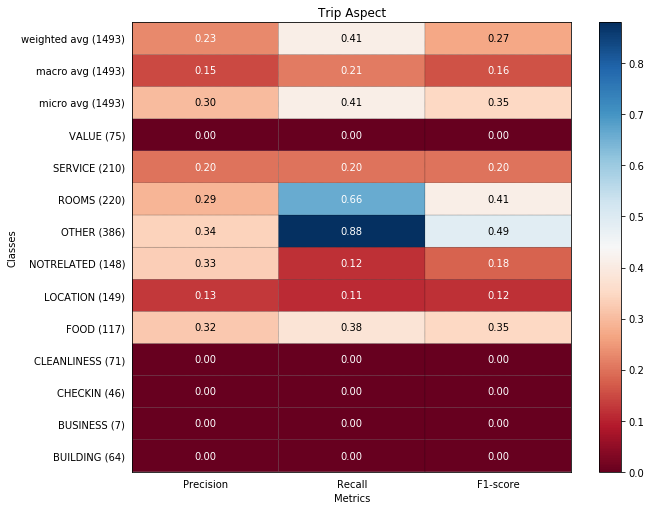

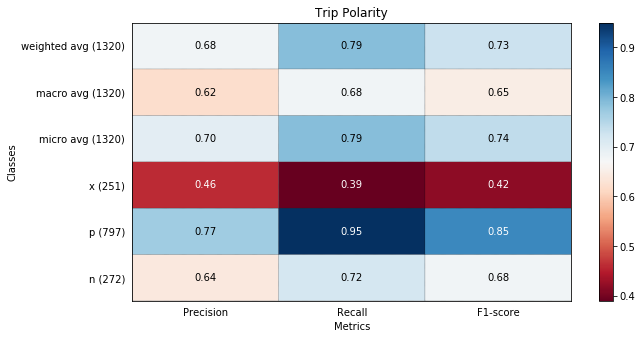

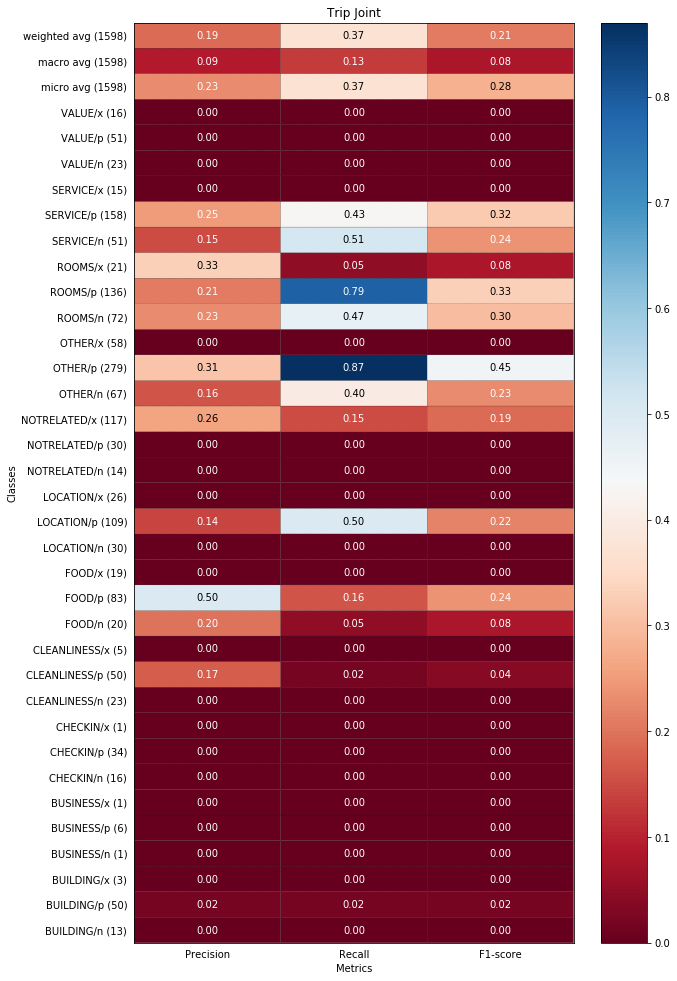

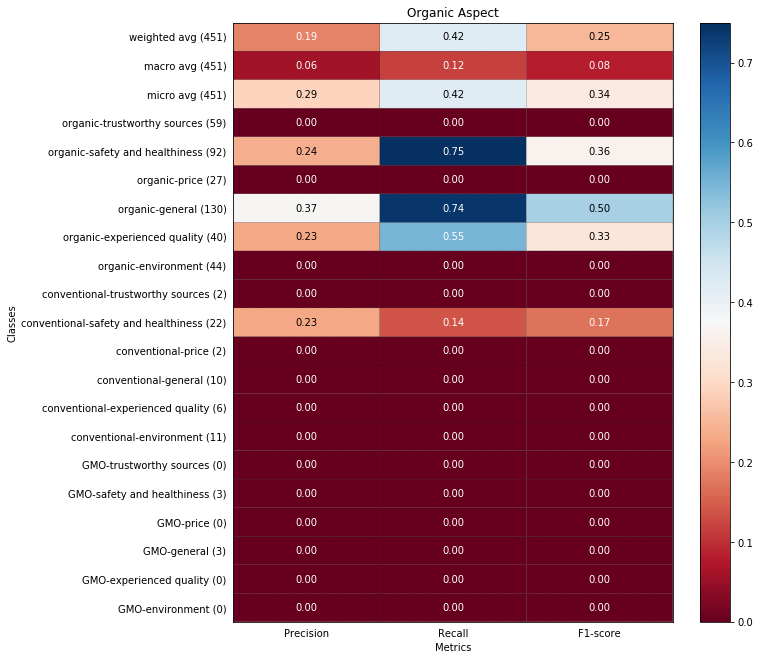

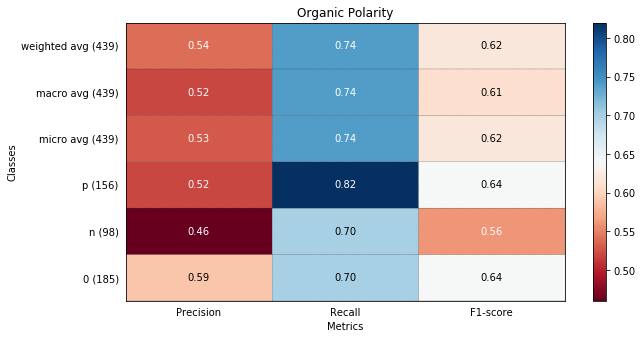

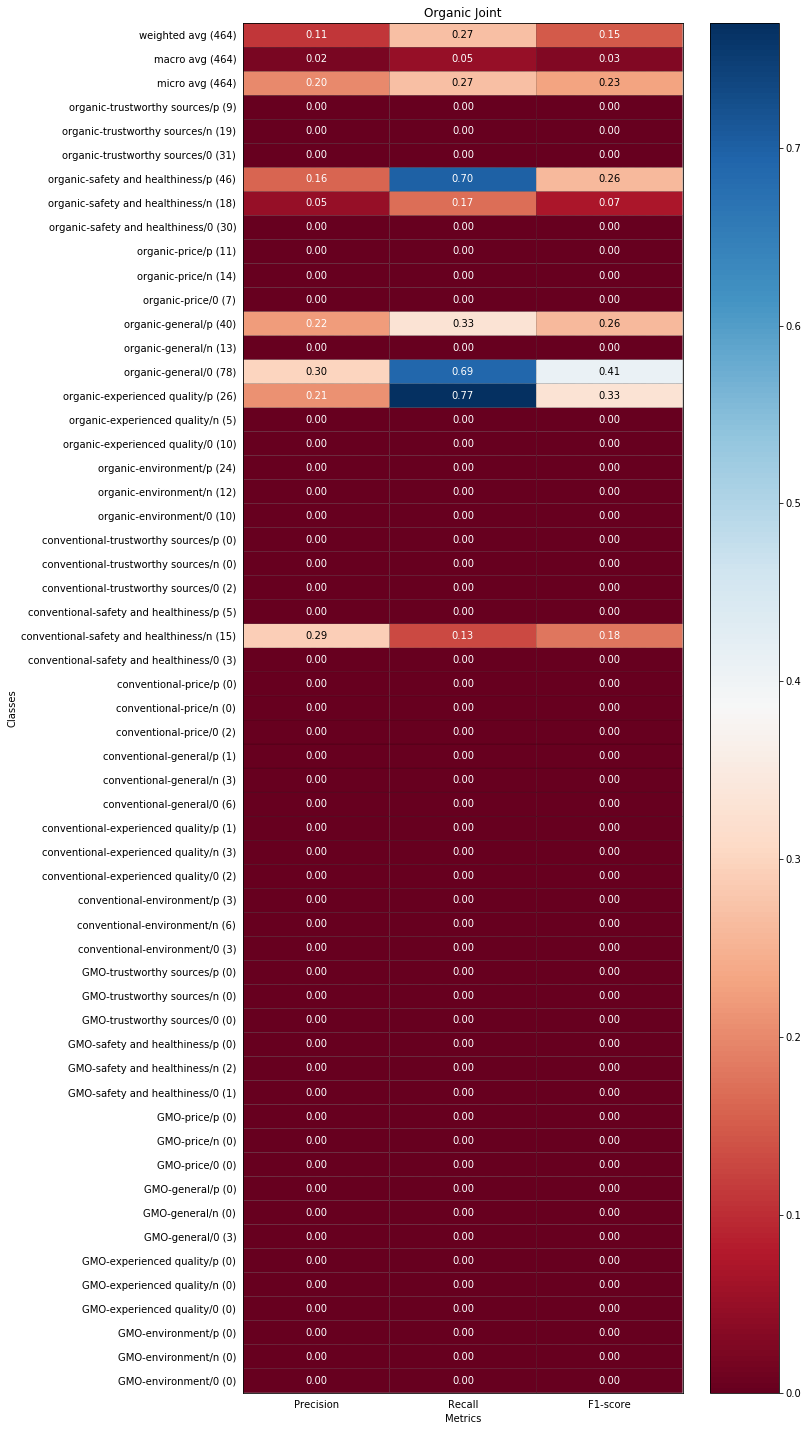

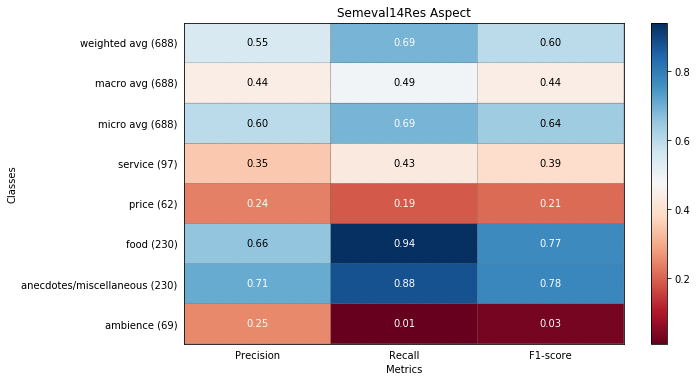

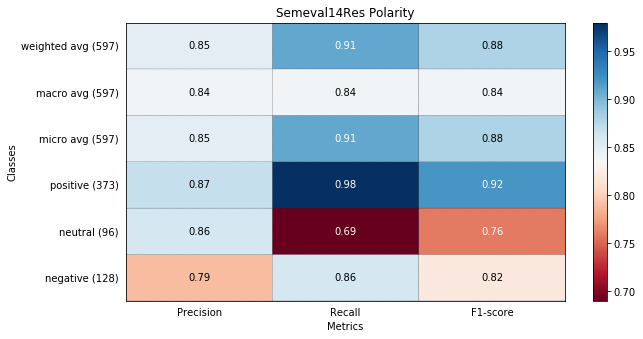

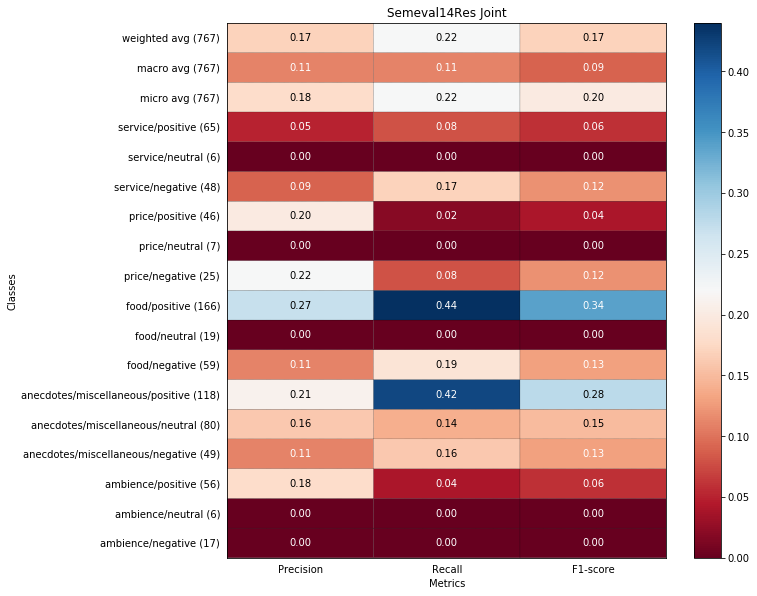

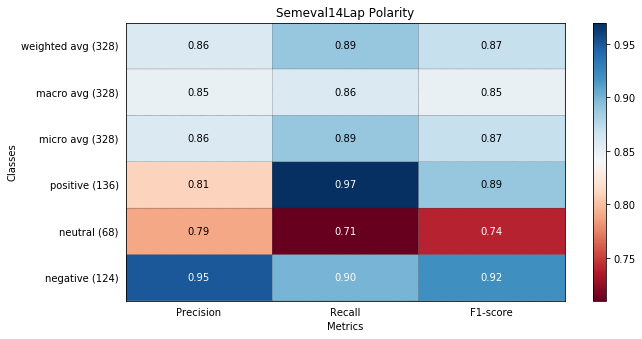

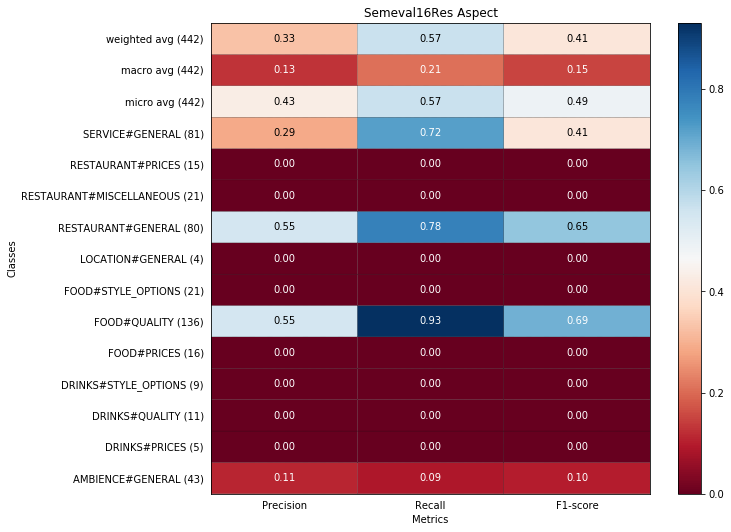

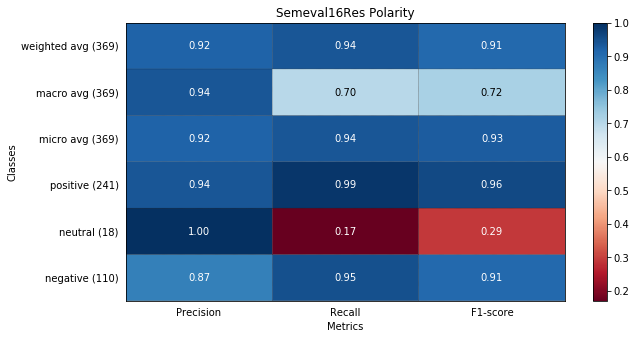

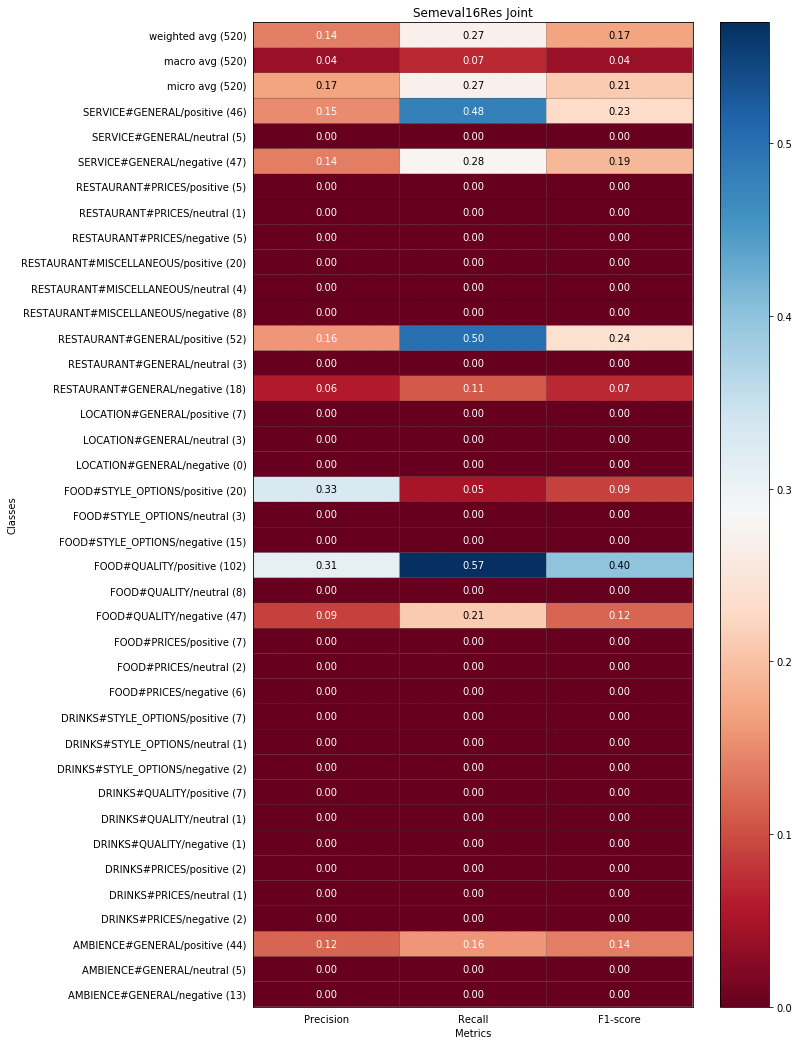

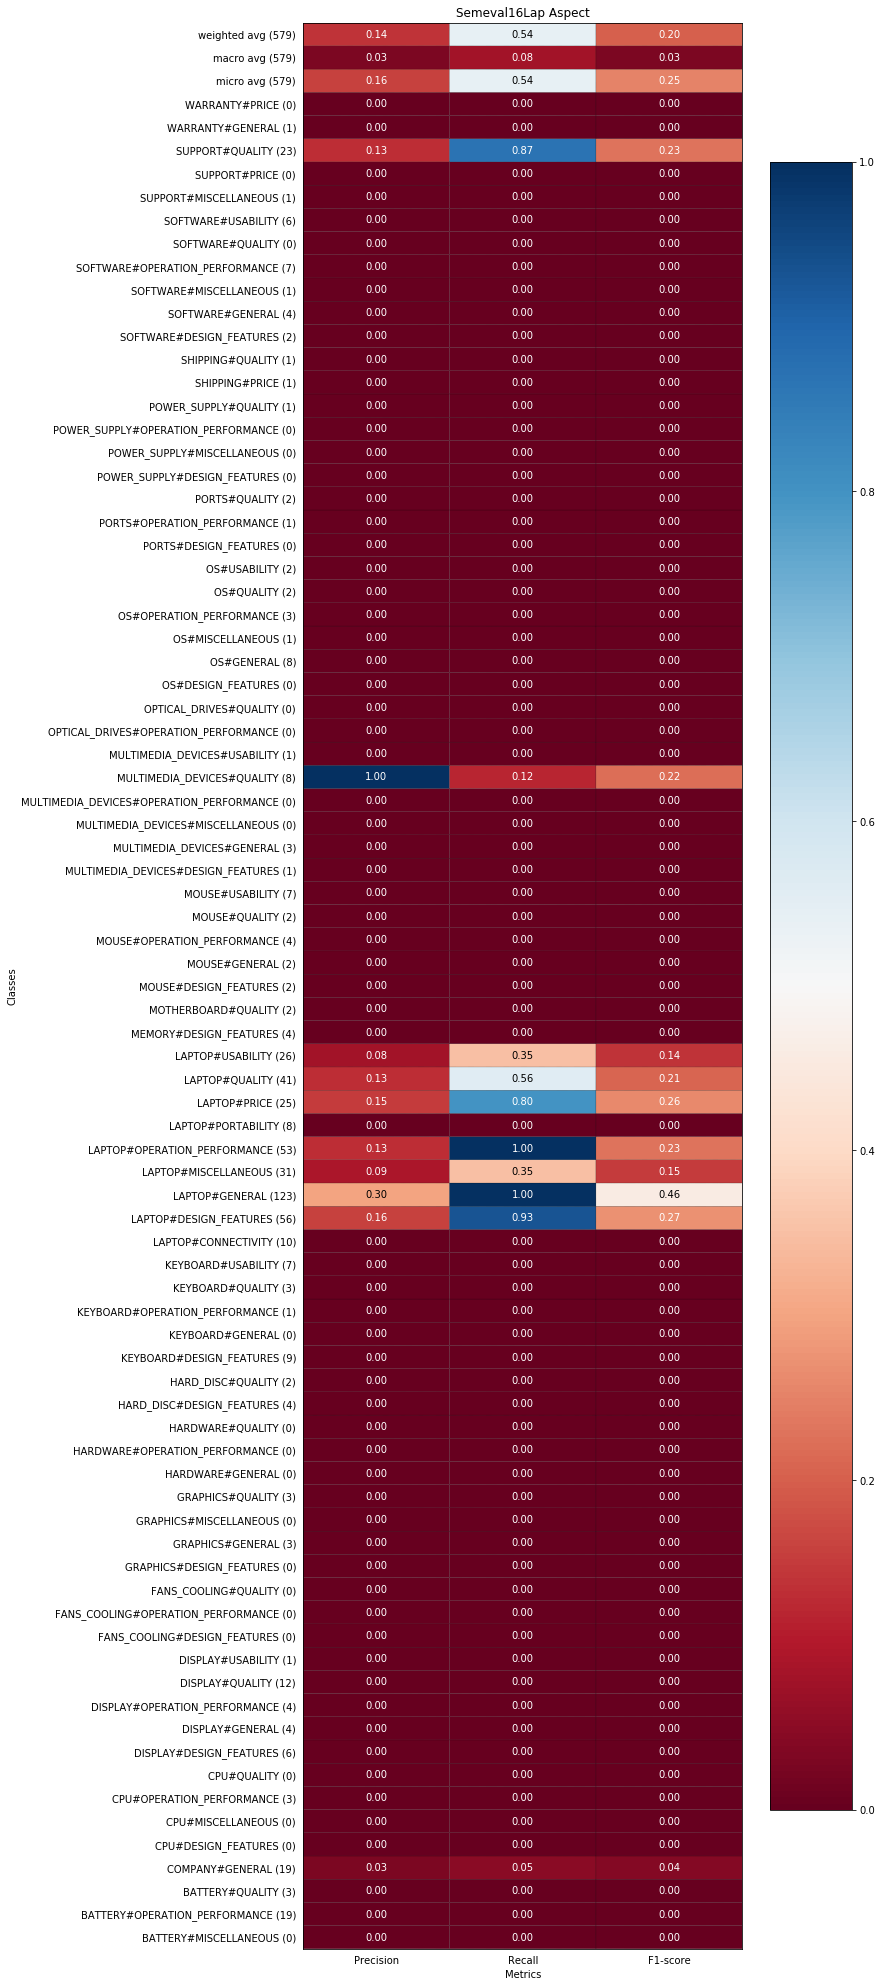

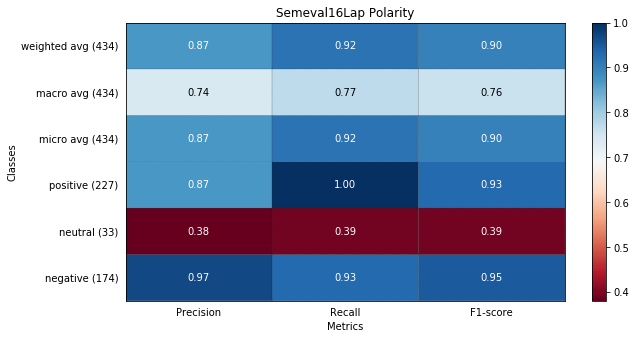

In [0]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

'''
model = MHCBERT()
model.load_state_dict(torch.load(os.path.join(args.save_dir, WEIGHTS_NAME)))
model.eval()
model.to(device)
'''

model.eval()

complete_data = {}
for domain in config:
    complete_data[domain["name"]] = evaluate_on_test(domain, {  'aspect': domain["data_test"].aspect_encoder.classes_,
                                'polarity': domain["data_test"].polarity_encoder.classes_,
                                'joint': domain["data_test"].joint_encoder.classes_  })
